# Frequency dependent membrane polarization across neocortical cell types and subcellular elements by transcranial alternating current stimulation.

## Some help functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection
import time, os
import scipy.io as scio 
import h5py
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score
import math

In [2]:
import os, subprocess
def svg_to_emf(svg_figpath):
    if True:
        cwd_path = os.getcwd()
        svg_figpath = os.path.join(cwd_path, svg_figpath)
        print(svg_figpath)
    inkscape_path = 'D:\\Pycharm\\Inkscape\\bin\\inkscape.exe' 
    if svg_figpath is not None:
        path, svgfigname = os.path.split(svg_figpath)
        figname, figform = os.path.splitext(svgfigname)
        emf_figpath = os.path.join(path, figname + '.emf')
        subprocess.call("{} {} -T -o {}".format(inkscape_path, svg_figpath, emf_figpath), shell=True)
        # os.remove(svg_figpath)

def continous_phase(data):
    dataout = np.zeros_like(data)
    dataout[0] = data[0]
    for i in range(1, len(data)):
        if data[i]-dataout[i-1] > 100:
            dataout[i]  = data[i] - 180
        elif data[i]-dataout[i-1] < -100:
            dataout[i] = data[i] + 180
        else:
            dataout[i] = data[i]
    return dataout

## Fig. 1: Cell morphologies.

In [3]:
mat_dir = r'H:\Polarization_By_tACS\mat'
datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_morphology.mat')
data_h5py = h5py.File(datafile, 'r')
data = data_h5py['data_mor']

list_xzlim = []
for i in range(5):
    list_xdata = []
    list_zdata = []
    for num in np.arange(i, 25, 5):
        data_soma = data_h5py[data[0, num]]['coord_soma'][:]
        data_axon = data_h5py[data[0, num]]['coord_axon'][:].transpose()
        data_basal = data_h5py[data[0, num]]['coord_basal'][:].transpose()
        xdata = np.hstack((data_soma[0], data_axon[0], data_basal[0]))
        zdata = np.hstack((data_soma[2], data_axon[2], data_basal[2]))
        if 'coord_apic' in data_h5py[data[0, num]].keys():
            data_apic = data_h5py[data[0, num]]['coord_apic'][:].transpose()
            xdata = np.hstack((xdata, data_apic[0]))
            zdata = np.hstack((zdata, data_apic[2]))
        list_xdata.append([np.nanmin(xdata), np.nanmax(xdata)])
        list_zdata.append([np.nanmin(zdata), np.nanmax(zdata)])
    list_xdata = np.array(list_xdata).transpose()
    list_zdata = np.array(list_zdata).transpose()
    list_xzlim.append([np.min(list_xdata[0]), np.nanmax(list_xdata[1]), np.min(list_zdata[0]), np.nanmax(list_zdata[1])])
    print('xmin=%.2f, xmax=%.2f, zmin=%.2f, zmax=%.2f' % (np.min(list_xdata[0]), np.nanmax(list_xdata[1]), np.min(list_zdata[0]), np.nanmax(list_zdata[1])))

xmin=-479.27, xmax=286.11, zmin=-228.74, zmax=129.57
xmin=-1746.02, xmax=1011.79, zmin=-1346.32, zmax=512.29
xmin=-830.48, xmax=520.46, zmin=-767.76, zmax=740.13
xmin=-1066.69, xmax=1228.12, zmin=-1125.96, zmax=1202.40
xmin=-989.26, xmax=693.91, zmin=-820.80, zmax=1294.17


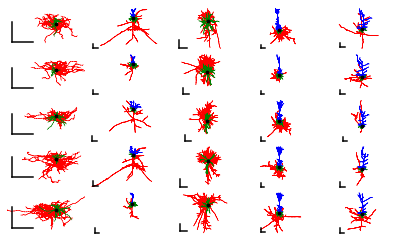

In [4]:
num = 0
lw = 0.6
fig, ax = plt.subplots(5, 5, figsize=(7, 4.2))
for i in range(5):
    for j in range(5):
        data_soma = data_h5py[data[0, num]]['coord_soma'][:]
        data_axon = data_h5py[data[0, num]]['coord_axon'][:].transpose()
        data_basal = data_h5py[data[0, num]]['coord_basal'][:].transpose()
        ax[i, j].plot(data_axon[0], data_axon[2], color='r', zorder=-3, lw=lw)
        ax[i, j].plot(data_basal[0], data_basal[2], color='g', zorder=-2, lw=lw)
        if 'coord_apic' in data_h5py[data[0, num]].keys():
            data_apic = data_h5py[data[0, num]]['coord_apic'][:].transpose()
            ax[i, j].plot(data_apic[0], data_apic[2], color='b', zorder=-1, lw=lw)
        ax[i, j].scatter(data_soma[0], data_soma[2], color='k', s=8, zorder=1)
        num += 1
        ax[i, j].axis('equal')
        ax[i, j].axis('off')
        ax[i, j].set_xlim(list_xzlim[j][0], list_xzlim[j][1])
        ax[i, j].plot([list_xzlim[j][0]+50, list_xzlim[j][0]+50+200], [list_xzlim[j][2]+50, list_xzlim[j][2]+50], color='k')
        ax[i, j].plot([list_xzlim[j][0]+50, list_xzlim[j][0]+50], [list_xzlim[j][2]+50, list_xzlim[j][2]+50+200], color='k')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)

## Fig. 2: Sensitivity to EF direction.

In [5]:
mat_dir = r'H:\Polarization_By_tACS\mat'
datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_direction.mat')
data_h5py = h5py.File(datafile, 'r')
polarsoma = data_h5py['data_figure_direction_soma'][:].transpose(2, 1, 0)
list_theta = data_h5py['list_theta'][:].squeeze()
list_phi = data_h5py['list_phi'][:].squeeze()
list_theta_flip = list_theta[::-1]

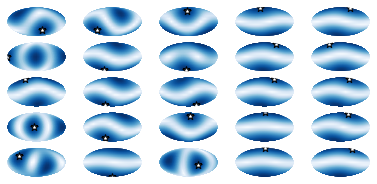

In [6]:
'''1mV/mm, 10Hz, peak soma polarization length'''
fig = plt.figure(figsize=(6.5, 3.2))
num = 0
for i in range(5):
    for j in range(5):
        num += 1 
        idxmax = np.unravel_index(np.argmax(polarsoma[num-1]), polarsoma[num-1].shape)
        ax = fig.add_subplot(5, 5, num, projection="mollweide")
        norm = colors.Normalize(vmin=polarsoma[num-1].min(), vmax=polarsoma[num-1].max())
        ax.pcolormesh(list_phi, list_theta, np.flip(polarsoma[num-1], axis=0), shading='auto', cmap='Blues', norm=norm)
        ax.scatter(list_phi[idxmax[1]], list_theta_flip[idxmax[0]], marker='*', s=60, ec='k', fc='w')
        ax.axis('off')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.05)

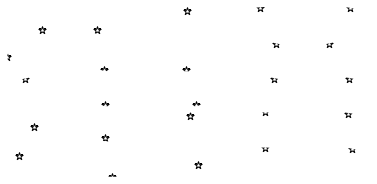

In [7]:
fig = plt.figure(figsize=(6.5, 3.2))
num = 0
for i in range(5):
    for j in range(5):
        num += 1 
        idxmax = np.unravel_index(np.argmax(polarsoma[num-1]), polarsoma[num-1].shape)
        ax = fig.add_subplot(5, 5, num, projection="mollweide")
        norm = colors.Normalize(vmin=polarsoma[num-1].min(), vmax=polarsoma[num-1].max())
        # ax.pcolormesh(list_phi, list_theta, np.flip(polarsoma[num-1], axis=0), shading='auto', cmap='Blues', norm=norm)
        ax.scatter(list_phi[idxmax[1]], list_theta_flip[idxmax[0]], marker='*', s=60, ec='k', fc='w')
        ax.axis('off')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.05)

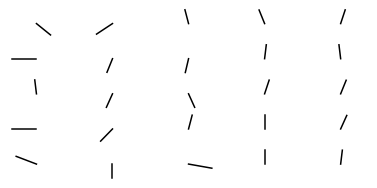

In [8]:
fig = plt.figure(figsize=(6.5, 3.2))
num = 0
for i in range(5):
    for j in range(5):
        num += 1 
        idxmax = np.unravel_index(np.argmax(polarsoma[num-1]), polarsoma[num-1].shape)
        theta = list_theta_flip[idxmax[0]]
        phi = list_phi[idxmax[1]]
        dz = np.sin(theta)
        dx = np.cos(theta)*np.sin(phi)
        normlength = np.sqrt(dx*dx+dz*dz)
        ax = fig.add_subplot(5, 5, num)
        # ax.arrow(0, 0, dx/normlength, dz/normlength, width=0.1, fc='k', ec='none', length_includes_head=True)
        ax.plot([0, dx/normlength], [0, dz/normlength], linewidth=1.5, color='k')

        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.axis('off')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.05)

## Fig. 3: Sensitivity to EF intensity.

In [9]:
mat_dir = r'H:\Polarization_By_tACS\mat'
datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_intensity.mat')

data_h5py = h5py.File(datafile, 'r')
data = data_h5py['data_figure_maxVmDeflection']
list_amp = data_h5py['list_amp'][:].squeeze()

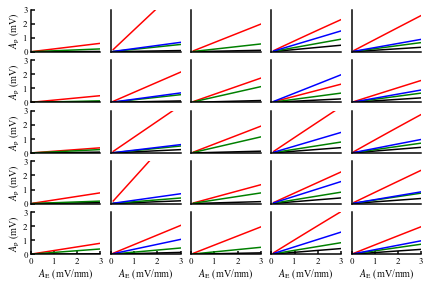

In [10]:
plt.rcParams.update({
    'font.size': 9,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1.5
num = 0
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
fig, ax = plt.subplots(5, 5, figsize=(7, 4.5))
for i in range(5):
    for j in range(5):
        ax[i, j].plot(list_amp, data_h5py[data[0][num]]['polar_soma'][0], color='k', lw=linewidth)
        ax[i, j].plot(list_amp, data_h5py[data[0][num]]['polar_axon'][0], color='r', lw=linewidth)
        ax[i, j].plot(list_amp, data_h5py[data[0][num]]['polar_basal'][0], color='g', lw=linewidth)
        if 'polar_apic' in data_h5py[data[0, num]].keys():
            ax[i, j].plot(list_amp, data_h5py[data[0][num]]['polar_apic'][0], color='b', lw=linewidth)
        num += 1
        ax[i, j].set_xlim(0, 3)
        ax[i, j].set_ylim(0, 3)
        if j != 0:
            ax[i, j].set_yticks([])
        else:
            ax[i, j].set_yticks([0, 1, 2, 3])
        if i != 4:
            ax[i, j].set_xticks([])
        else:
            ax[i, j].set_xticks([0, 1, 2, 3])
        if j==0:
            ax[i, j].set_ylabel('$\mathit{A}_{\mathrm{p}}$ (mV)', fontsize=10, labelpad=2)
        if i==4:
            ax[i, j].set_xlabel('$\mathit{A}_{\mathrm{E}}$ (mV/mm)', fontsize=10, labelpad=2)
        ax[i, j].spines['top'].set_color('none')
        ax[i, j].spines['right'].set_color('none')
        ax[i, j].spines['bottom'].set_linewidth(linewidth)
        ax[i, j].spines['left'].set_linewidth(linewidth)
        ax[i, j].tick_params(pad=3)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.2)

## Fig. 4: Polarization length varies between subcellular elements and cell types.

In [11]:
mat_dir = r'H:\Polarization_By_tACS\mat'
datafileidx = os.path.join(mat_dir, 'snowp_data\\1mV_10Hz_subcell_index.mat')
data_h5pyidx = h5py.File(datafileidx, 'r')

datafile = os.path.join(mat_dir, 'snowp_data\polarization_1mV_10Hz_25cells_Default.mat')
data_h5py = h5py.File(datafile, 'r')
polarize_amp = data_h5py['polarize_amp']
polarize_phase = data_h5py['polarize_phase']
peakpolar      = np.zeros((4, 5, 5)) # polarization length, 4=(soma, axon, basal, apic), 5*5=(cell types, clones)
peakpolarphase = np.zeros((4, 5, 5)) # polarization phase
num = 0
maxpolar_index_1mV10HZ = np.zeros((25, 4)).astype(np.int32)
for num in range(25):
    polar_amp   = data_h5py[polarize_amp[  0, num]][:].squeeze()
    polar_phase = data_h5py[polarize_phase[0, num]][:].squeeze()
    idxsoma = data_h5pyidx[data_h5pyidx['subcell_index'][0, num]][:].squeeze().astype(np.int32); idxsoma = np.array([idxsoma])
    idxaxon = data_h5pyidx[data_h5pyidx['subcell_index'][1, num]][:].squeeze().astype(np.int32)
    idxbasal= data_h5pyidx[data_h5pyidx['subcell_index'][2, num]][:].squeeze().astype(np.int32)
    idxmaxsoma = idxsoma[np.argmax(polar_amp[ idxsoma])] + 1
    idxmaxaxon = idxaxon[np.argmax(polar_amp[ idxaxon])] + 1
    idxmaxbasal= idxbasal[np.argmax(polar_amp[idxbasal])] + 1
    maxpolar_index_1mV10HZ[num, 0] = idxmaxsoma
    maxpolar_index_1mV10HZ[num, 1] = idxmaxaxon
    maxpolar_index_1mV10HZ[num, 2] = idxmaxbasal
    if num in [5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]:
        idxapic = data_h5pyidx[data_h5pyidx['subcell_index'][3, num]][:].squeeze().astype(np.int32)
        idxmaxapic = idxapic[np.argmax(polar_amp[idxapic])] + 1
        maxpolar_index_1mV10HZ[num, 3] = idxmaxapic

savefile = os.path.join(mat_dir, 'snowp_data\maxpolar_index_1mV_10Hz.npy')
np.save(savefile, maxpolar_index_1mV10HZ)
    
savefile = os.path.join(mat_dir, 'snowp_data\maxpolar_index_1mV_10Hz.mat')
import scipy.io as scio
scio.savemat(savefile,  {'maxpolar_index_1mV_10Hz': maxpolar_index_1mV10HZ} )

In [12]:
polarization_sign = np.zeros((4, 5, 5))
# soma 
polarization_sign[0][0] = np.array([-1, -1, -1, -1, -1]) # L1 NGC
polarization_sign[0][1] = np.array([ 1,  1,  1,  1,  1]) # L2/3 PC
polarization_sign[0][2] = np.array([ 1,  1,  1,  1,  1]) # L4 LBC
polarization_sign[0][3] = np.array([-1, -1, -1, -1, -1]) # L5 PC
polarization_sign[0][4] = np.array([-1, -1, -1, -1, -1]) # L6 PC
# axon
polarization_sign[1][0] = np.array([ 1,  1, -1, -1,  1])
polarization_sign[1][1] = np.array([ 1,  1,  1,  1,  1])
polarization_sign[1][2] = np.array([-1,  1, -1, -1, -1])
polarization_sign[1][3] = np.array([-1, -1, -1, -1, -1])
polarization_sign[1][4] = np.array([-1, -1,  1, -1, -1])
# basal
polarization_sign[2][0] = np.array([ 1, -1, -1, -1, -1])
polarization_sign[2][1] = np.array([ 1,  1,  1,  1,  1])
polarization_sign[2][2] = np.array([ 1,  1,  1, -1, -1])
polarization_sign[2][3] = np.array([-1, -1, -1, -1, -1])
polarization_sign[2][4] = np.array([-1, -1, -1, -1, -1])
# apic
polarization_sign[3][0] = np.array([ 0,  0,  0,  0,  0])
polarization_sign[3][1] = np.array([-1, -1, -1, -1, -1])
polarization_sign[3][2] = np.array([ 0,  0,  0,  0,  0])
polarization_sign[3][3] = np.array([ 1,  1,  1,  1,  1])
polarization_sign[3][4] = np.array([ 1,  1,  1,  1,  1])

savefile = os.path.join(mat_dir, 'snowp_data\polarization_sign_1mV_10Hz.npy')
# np.save(savefile, polarization_sign)
polarization_sign = np.load(savefile)

In [13]:
mat_dir = r'H:\Polarization_By_tACS\mat'
datafileidx = os.path.join(mat_dir, 'snowp_data\\1mV_10Hz_subcell_index.mat')
data_h5pyidx = h5py.File(datafileidx, 'r')
datafile = os.path.join(mat_dir, 'snowp_data\polarization_1mV_10Hz_25cells_Default.mat')
data_h5py = h5py.File(datafile, 'r')
polarize_amp = data_h5py['polarize_amp']
polarize_phase = data_h5py['polarize_phase']
peakpolar      = np.zeros((4, 5, 5)) # polarization length, 4=(soma, axon, basal, apic), 5*5=(cell types, clones)
peakpolarphase = np.zeros((4, 5, 5)) # polarization phase
num = 0
for i in range(5): # cell types
    for j in range(5): # clones
        idxsoma = data_h5pyidx[data_h5pyidx['subcell_index'][0, num]][:].squeeze().astype(np.int32); idxsoma = np.array([idxsoma])
        idxaxon = data_h5pyidx[data_h5pyidx['subcell_index'][1, num]][:].squeeze().astype(np.int32)
        idxbasal= data_h5pyidx[data_h5pyidx['subcell_index'][2, num]][:].squeeze().astype(np.int32)
        polar_amp   = data_h5py[polarize_amp[  0, num]][:].squeeze()
        polar_phase = data_h5py[polarize_phase[0, num]][:].squeeze()
        idxmaxsoma = idxsoma[np.argmax(polar_amp[ idxsoma])]
        idxmaxaxon = idxaxon[np.argmax(polar_amp[ idxaxon])]
        idxmaxbasal= idxbasal[np.argmax(polar_amp[idxbasal])]
        if num not in [0, 1, 2, 3, 4, 10, 11, 12, 13, 14]:
            idxapic = data_h5pyidx[data_h5pyidx['subcell_index'][3, num]][:].squeeze().astype(np.int32)
            idxmaxapic = idxapic[np.argmax(polar_amp[idxapic])]
        negativa_polar_index = polar_phase>180
        polar_amp[negativa_polar_index] = -polar_amp[negativa_polar_index]
        polar_phase[negativa_polar_index] -= 180
        peakpolar[0, i, j] = polar_amp[ idxmaxsoma] # soma
        peakpolar[1, i, j] = polar_amp[ idxmaxaxon] # axon
        peakpolar[2, i, j] = polar_amp[idxmaxbasal] # basal
        peakpolarphase[0, i, j] = polar_phase[ idxmaxsoma] # soma
        peakpolarphase[1, i, j] = polar_phase[ idxmaxaxon] # axon
        peakpolarphase[2, i, j] = polar_phase[idxmaxbasal] # basal
        if num not in [0, 1, 2, 3, 4, 10, 11, 12, 13, 14]:
            peakpolar[3, i, j]      = polar_amp[idxmaxapic] # apic
            peakpolarphase[3, i, j] = polar_phase[idxmaxapic] # apic
        num += 1

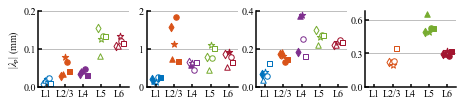

In [14]:
peakpolar_abs = np.abs(peakpolar)
peakpolar = peakpolar_abs * polarization_sign
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})

linewidth = 1.
colors = ['#0072BD', '#D95319', '#7E2F8E', '#77AC30', '#A2142F']
marker = ['d','^','*','o','s']
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
fig, ax = plt.subplots(1, 4, figsize=(7.5, 1.4))
for m in range(4):
    for i in range(5):
        for j in range(5):
            if peakpolar[m][i, j] != 0:
                if peakpolar[m][i, j] >= 0:
                    fc = colors[i]
                else:
                    fc = 'w'
                zorder = 1
                if marker[j] in ['d']:
                    ax[m].scatter(i+0.1*(j-2), peakpolar_abs[m][i, j], color=colors[i], marker=marker[j], linewidth=linewidth, fc=fc, s=65-30, zorder=zorder)
                elif marker[j] in ['^']:
                    ax[m].scatter(i+0.1*(j-2), peakpolar_abs[m][i, j], color=colors[i], marker=marker[j], linewidth=linewidth, fc=fc, s=60-30, zorder=zorder)
                elif marker[j] in ['*']:
                    ax[m].scatter(i+0.1*(j-2), peakpolar_abs[m][i, j], color=colors[i], marker=marker[j], linewidth=linewidth, fc=fc, s=75-30, zorder=zorder)
                elif marker[j] in ['o']:
                    ax[m].scatter(i+0.1*(j-2), peakpolar_abs[m][i, j], color=colors[i], marker=marker[j], linewidth=linewidth, fc=fc, s=60-30, zorder=zorder)
                elif marker[j] in ['s']:
                    ax[m].scatter(i+0.1*(j-2), peakpolar_abs[m][i, j], color=colors[i], marker=marker[j], linewidth=linewidth, fc=fc, s=55-30, zorder=zorder)
    ax[m].set_xlim(-0.5, 4.5)
    ax[m].set_ylim(0, )
    ax[m].spines['top'].set_color('none')
    ax[m].spines['right'].set_color('none')
    ax[m].set_xticks(range(5))
    ax[m].set_xticklabels(['L1', 'L2/3', 'L4', 'L5', 'L6'])
    ax[m].spines['bottom'].set_linewidth(1.5)
    ax[m].spines['left'].set_linewidth(1.5)
    ax[m].tick_params(pad=2)
    if m==0:
        ax[m].set_yticks([0, 0.1, 0.2])
        ax[m].set_ylabel('|$\mathit{\lambda}_{\mathrm{p}}$| (mm)', fontsize=10, labelpad=2)
        ax[m].axhline(0.1, c='grey', lw=0.5, zorder=-1)
        ax[m].axhline(0.2, c='grey', lw=0.5, zorder=-1)
    if m==1:
        ax[m].tick_params(axis='y', pad=3)
        ax[m].set_yticks([0, 1, 2])
        ax[m].set_ylim(0, 2)
        ax[m].axhline(1, c='grey', lw=0.5, zorder=-1)
        ax[m].axhline(2, c='grey', lw=0.5, zorder=-1)
    if m==2:
        ax[m].set_yticks([0, 0.2, 0.4])
        ax[m].set_ylim(0, 0.4)
        ax[m].axhline(0.2, c='grey', lw=0.5, zorder=-1)
        ax[m].axhline(0.4, c='grey', lw=0.5, zorder=-1)
    if m==3:
        ax[m].set_yticks([0, 0.3, 0.6])
        ax[m].set_ylim(0, 0.68)
        ax[m].axhline(0.3, c='grey', lw=0.5, zorder=-1)
        ax[m].axhline(0.6, c='grey', lw=0.5, zorder=-1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.0)

## Fig. 5: Dependence of polarization length on field frequency

In [15]:
mat_dir = r'H:\Polarization_By_tACS\mat'
datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_AmpFreq_Default.mat')

data_h5py = h5py.File(datafile, 'r')
data = data_h5py['data_figure_ampfreq']
list_f = data_h5py['list_f'][:].squeeze()

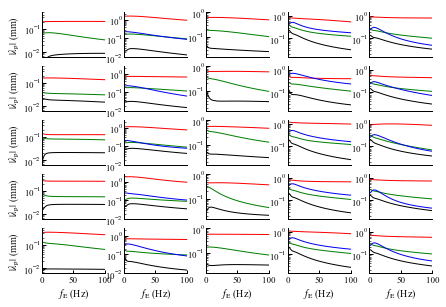

In [16]:
plt.rcParams.update({
    'font.size': 9,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1.
num = 0
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
fig, ax = plt.subplots(5, 5, figsize=(7, 4.8))
for i in range(5):
    for j in range(5):
        ax[i, j].semilogy(list_f, data_h5py[data[0][num]]['polar_soma'][0], color='k', lw=linewidth)
        ax[i, j].semilogy(list_f, data_h5py[data[0][num]]['polar_axon'][0], color='r', lw=linewidth)
        ax[i, j].semilogy(list_f, data_h5py[data[0][num]]['polar_basal'][0], color='g', lw=linewidth)
        if 'polar_apic' in data_h5py[data[0, num]].keys():
            ax[i, j].semilogy(list_f, data_h5py[data[0][num]]['polar_apic'][0], color='b', lw=linewidth)
        num += 1
        ax[i, j].set_xlim(0, 100)
        ax[i, j].spines['top'].set_color('none')
        ax[i, j].spines['right'].set_color('none')
        ax[i, j].spines['bottom'].set_linewidth(linewidth)
        ax[i, j].spines['left'].set_linewidth(linewidth)
        if j == 0:
            ax[i, j].set_ylim(6e-3, 5e-1)
        if j == 1:
            ax[i, j].set_ylim(1e-2, 2.5e0)
        if j == 2:
            ax[i, j].set_ylim(1.5e-2, 1e0)
        if j == 3:
            ax[i, j].set_ylim(1.5e-2, 1.4e0)
        if j == 4:
            ax[i, j].set_ylim(1.5e-2, 1.4e0)
            
        if i!=4:
            ax[i, j].set_xticks([])
        if i==4:
            ax[i, j].set_xticks([0, 50, 100])
        ax[i, j].tick_params(axis='y', pad=1)
        ax[i, j].tick_params(axis='x', pad=3)
        if i==4:
            ax[i, j].set_xlabel('$f_{\mathrm{E}}$ (Hz)', fontsize=10, fontfamily='Times new roman', labelpad=2)
        if j==0:
            ax[i, j].set_ylabel("$|\lambda _{\mathrm{p}}|$ (mm)", fontsize=10, fontfamily='Times new roman', labelpad=2)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.2)   

## Fig. 6: Dependence of polarization phase on field frequency.

In [17]:
mat_dir = r'H:\Polarization_By_tACS\mat'
datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_PhaseFreq_Default.mat')

data_h5py = h5py.File(datafile, 'r')
data = data_h5py['data_figure_phasefreq']
list_f = data_h5py['list_f'][:].squeeze()

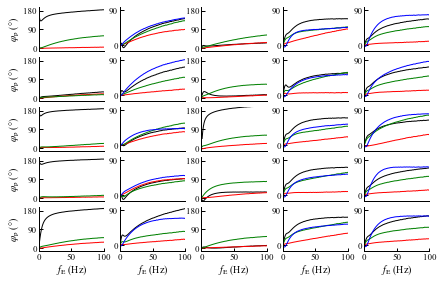

In [18]:
plt.rcParams.update({
    'font.size': 9,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1.
num = 0
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
fig, ax = plt.subplots(5, 5, figsize=(7, 4.5))
for i in range(5):
    for j in range(5):
        '''soma phase'''
        tempy = data_h5py[data[0][num]]['phase_soma'][0]
        tempy = continous_phase(tempy)
        if i==3 and j ==2:
            tempy -= 180
        ax[i, j].plot(list_f, tempy, color='k', lw=linewidth)
        
        '''axon phase'''
        tempy = data_h5py[data[0][num]]['phase_axon'][0]
        tempy[tempy>150] -= 180
        ax[i, j].plot(list_f, tempy, color='r', lw=linewidth)
        
        '''basal phase'''
        tempy = data_h5py[data[0][num]]['phase_basal'][0]
        tempy = continous_phase(tempy)
        ax[i, j].plot(list_f, tempy, color='g', lw=linewidth)

        '''apic phase'''
        if 'phase_apic' in data_h5py[data[0, num]].keys():
            tempy = data_h5py[data[0][num]]['phase_apic'][0]
            tempy[tempy>150] -= 180
            ax[i, j].plot(list_f, tempy, color='b', lw=linewidth)
            
        num += 1
        ax[i, j].set_xlim(0, 100)
        ax[i, j].spines['top'].set_color('none')
        ax[i, j].spines['right'].set_color('none')
        ax[i, j].spines['bottom'].set_linewidth(linewidth)
        ax[i, j].spines['left'].set_linewidth(linewidth)
        if i!=4:
            ax[i, j].set_xticks([])
        if j in [1, 3, 4]:
            ax[i, j].set_ylim(-15, 100)
            ax[i, j].set_yticks([0, 90])
        if i==4:
            ax[i, j].set_xticks([0, 50, 100])
        if j==0 or j==2:
            ax[i, j].set_ylim(-15, 200)
            ax[i, j].set_yticks([0, 90, 180])
        ax[i, j].tick_params(pad=2)
        if i==4:
            ax[i, j].set_xlabel('$f_{\mathrm{E}}$ (Hz)', fontsize=10, fontfamily='Times new roman', labelpad=2)
        if j==0:
            ax[i, j].set_ylabel(r"$\varphi_{\mathrm{p}}$ (°)", fontsize=10, fontfamily='Times new roman', labelpad=2)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.12)

## Fig. 7: Effect of cell morphology on polarization.

In [19]:
mat_dir = r'H:\Polarization_By_tACS\mat'
datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_moreffect.mat')

data_h5py = h5py.File(datafile, 'r')
data = data_h5py['data_figure_sub_peakpolar']
data_h5py[data[0, 0]].keys()

list_subnames = ['soma', 'axon', 'basal', 'apic', 'allsub']
list_x = []; list_y = []
list_x_clone = []; list_y_clone = []
for i in range(5):
    subname = list_subnames[i]
    for j in range(5):
        layer_proj = []
        layer_polar = []
        temp_clone_x = []
        temp_clone_y = []
        for m in range(5):
            num = np.array([0, 5, 10, 15, 20])
            layer_proj += data_h5py[data[0, num[m]+j]]['dist_proj'][:].squeeze().tolist()
            layer_polar += data_h5py[data[0, num[m]+j]]['polar_%s' % subname][:].squeeze().tolist()
            temp_clone_x.append(data_h5py[data[0, num[m]+j]]['dist_proj'][:].squeeze().tolist())
            temp_clone_y.append(data_h5py[data[0, num[m]+j]]['polar_%s' % subname][:].squeeze().tolist())
        list_x.append(layer_proj)
        list_y.append(layer_polar)
        list_x_clone.append(temp_clone_x)
        list_y_clone.append(temp_clone_y)

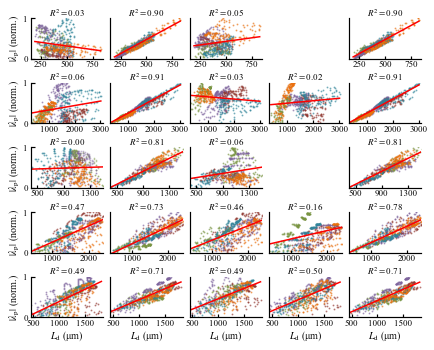

In [20]:
plt.rcParams.update({
    'font.size': 8,  
    'font.family': 'Times New Roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
})
linewidth = 1.2
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
list_xlim = [[150, 850], [300, 3100], [400, 1500], [400, 2400], [450, 1850]]
num = np.array([0, 5, 10, 15, 20])
fig, ax = plt.subplots(5, 5, figsize=(7, 5.5))
for i in range(5):
    for j in range(5):
        x = np.array(list_x[num[j]+i])[:, np.newaxis]
        y = np.array(list_y[num[j]+i])[:, np.newaxis]
        temp_ymin, temp_ymax = y.min(), y.max()
        if y.sum() != 0:
            '''Normlization'''
            y = (y-y.min())/(y.max()-y.min())
            xfit = np.linspace(x.min(), x.max(), x.shape[0])[:, np.newaxis]
            model = LinearRegression()
            model.fit(x, y)
            yfit = model.predict(xfit)
            colors = ['#923931', '#789440', '#7E649E', '#31859B', '#EA700D']
            for k in range(5):
                tempx = np.array(list_x_clone[num[j]+i][k])
                tempy = (np.array(list_y_clone[num[j]+i][k]) - temp_ymin) / (temp_ymax - temp_ymin)
                ax[i, j].scatter(tempx, tempy, s=0.8, color=colors[k], alpha=0.3)
            ax[i, j].plot(xfit, yfit, lw=1.5, color='r')
        ax[i, j].set_xlim(list_xlim[i])
        ax[i, j].set_ylim(0, 1)
        if i==4:
            ax[i, j].set_xlabel('$\mathit{L}_{\mathrm{d}}$ (μm)', fontsize=10, fontfamily='Times new roman', labelpad=2)
        if j==0:
            ax[i, j].set_ylabel("$|\lambda _{\mathrm{p}}|$ (norm.)", fontsize=10, fontfamily='Times new roman', labelpad=2)
        if j != 0:
            ax[i, j].set_yticks([])
        if j==0:
            ax[i, j].set_yticks([0, 1])
            ax[i, j].set_yticklabels(['0', '1'], fontdict={'fontfamily': 'times new roman'})
        if i==0:
            ax[i, j].set_title('$\mathit{R}^\mathrm{2}=$%.2f' % r2_score(y, model.predict(x)), fontsize=9, fontfamily='Times new roman', color='k', pad=0)
            ax[i, j].set_xticks([250, 500, 750])
            ax[i, j].set_xticklabels(['250', '500', '750'], fontdict={'fontfamily': 'times new roman'})
        if i==1:
            ax[i, j].set_title('$\mathit{R}^\mathrm{2}=$%.2f' % r2_score(y, model.predict(x)), fontsize=9, fontfamily='Times new roman', color='k', pad=0)
            ax[i, j].set_xticks([1000, 2000, 3000])
            ax[i, j].set_xticklabels(['1000', '2000', '3000'], fontdict={'fontfamily': 'times new roman'})
        if i==2:
            ax[i, j].set_title('$\mathit{R}^\mathrm{2}=$%.2f' % r2_score(y, model.predict(x)), fontsize=9, fontfamily='Times new roman', color='k', pad=0)
            ax[i, j].set_xticks([500, 900, 1300])
            ax[i, j].set_xticklabels(['500', '900', '1300'], fontdict={'fontfamily': 'times new roman'})
        if i==3:
            ax[i, j].set_title('$\mathit{R}^\mathrm{2}=$%.2f' % r2_score(y, model.predict(x)), fontsize=9, fontfamily='Times new roman', color='k', pad=0)
            ax[i, j].set_xticks([1000, 2000])
            ax[i, j].set_xticklabels(['1000', '2000'], fontdict={'fontfamily': 'times new roman'})
        if i==4:
            ax[i, j].set_title('$\mathit{R}^\mathrm{2}=$%.2f' % r2_score(y, model.predict(x)), fontsize=9, fontfamily='Times new roman', color='k', pad=0)
            ax[i, j].set_xticks([500, 1000, 1500])
            ax[i, j].set_xticklabels(['500', '1000', '1500'], fontdict={'fontfamily': 'times new roman'})
        ax[i, j].tick_params(labelsize=9, labelcolor='k', pad=2)
        ax[i, j].tick_params(axis='y', pad=3)
        ax[i, j].spines['top'].set_color('none')
        ax[i, j].spines['right'].set_color('none')
        ax[i, j].spines['bottom'].set_linewidth(linewidth)
        ax[i, j].spines['left'].set_linewidth(linewidth)
ax[0, 3].axis('off'); ax[0, 3].set_title('')
ax[2, 3].axis('off'); ax[2, 3].set_title('')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.6)

In [21]:
list_subnames = ['soma', 'axon', 'basal', 'apic', 'allsub']
list_r2 = []
for i in range(5):
    subname = list_subnames[i]
    for j in range(5):
        layer_r2 = []
        for m in range(5):
            num = np.array([0, 5, 10, 15, 20])
            x = data_h5py[data[0, num[m]+j]]['dist_proj'][:].transpose()
            y = data_h5py[data[0, num[m]+j]]['polar_%s' % subname][:].transpose()
            if y.sum() != 0:
                model = LinearRegression()
                model.fit(x, y)
                layer_r2.append(r2_score(y, model.predict(x)))
        list_r2.append(layer_r2)

r2_soma = np.array(list_r2[0:5]).transpose()  # column denotes clones, row denotes cell types
r2_axon = np.array(list_r2[5:10]).transpose()
r2_basal = np.array(list_r2[10:15]).transpose()
r2_apic = []
for i in [16, 18, 19]:
    r2_apic.append(list_r2[i])
r2_apic.insert(0, [0, 0, 0, 0, 0])
r2_apic.insert(2, [0, 0, 0, 0, 0])
r2_apic = np.array(r2_apic).transpose()
r2_allsub = np.array(list_r2[20:25]).transpose()
list_boxplot = [r2_soma, r2_axon, r2_basal, r2_apic, r2_allsub]

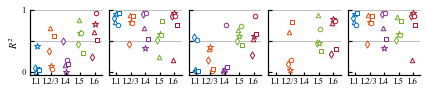

In [22]:
plt.rcParams.update({
    'font.size': 9,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1.2
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
colors = ['#0072BD', '#D95319', '#7E2F8E', '#77AC30', '#A2142F']
markers = ['d','^','*','o','s']
size = np.array([35, 30, 50, 30, 25]) - 10
fig, ax = plt.subplots(1, 5, figsize=(7, 1.2))
for i in range(5):
    for j in range(5): # layers
        for m in range(5): # clones
            if np.sum(list_boxplot[i].transpose()[j]) != 0.:
                ax[i].scatter(j+0.08*(m-2), list_boxplot[i].transpose()[j, m], marker=markers[m], s=size[m], lw=1, color=colors[j], fc='w', zorder=1)
    ax[i].set_xlim(-0.5, 4.5)
    ax[i].set_ylim(-0.05, 1.)
    ax[i].set_xticks([0, 1, 2, 3, 4])
    ax[i].set_xticklabels(['L1', 'L2/3', 'L4', 'L5', 'L6'])
    ax[i].set_yticks([0, 0.5, 1])
    ax[i].set_yticklabels(['0', '', '1'])
    ax[i].axhline(1, c='grey', lw=0.5, zorder=-1)
    ax[i].axhline(0.5, c='grey', lw=0.5, zorder=-1)
    if i==0:
        ax[i].set_ylabel('$\mathit{R}^2$', fontsize=10, labelpad=2)
    if i!=0:
        ax[i].set_yticklabels([])
    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')
    ax[i].spines['bottom'].set_linewidth(linewidth)
    ax[i].spines['left'].set_linewidth(linewidth)
    ax[i].tick_params(pad=3)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.)   

## Fig. 8: Effect of L5 excitatory dynamics on polarization.

In [23]:
mat_dir = r'H:\Polarization_By_tACS\mat'
datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_AmpFreq_Default.mat')
data_h5py_default = h5py.File(datafile, 'r')
data_default = data_h5py_default['data_figure_ampfreq']
list_f = data_h5py_default['list_f'][:].squeeze()

datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_AmpFreq_Exc.mat')
data_h5py_exc = h5py.File(datafile, 'r')
data_exc = data_h5py_exc['data_figure_ampfreq']

datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_AmpFreq_Inh.mat')
data_h5py_inh = h5py.File(datafile, 'r')
data_inh = data_h5py_inh['data_figure_ampfreq']

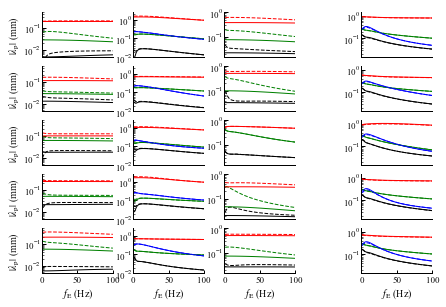

In [24]:
plt.rcParams.update({
    'font.size': 9,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1.
num = 0
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth

fig = plt.figure(figsize=(7, 4.8))
numcol = [0, 2, 4, 6, 7]
colspans = [2, 2, 2, 1, 2]
for i in range(5):
    for j in range(5):
        ax = plt.subplot2grid((5, 9), (i, numcol[j]), colspan=colspans[j])
        if j!=3:
            # default biophisics
            ax.semilogy(list_f, data_h5py_default[data_default[0][num]]['polar_soma'][0], color='k', lw=linewidth, ls='--')
            ax.semilogy(list_f, data_h5py_default[data_default[0][num]]['polar_axon'][0], color='r', lw=linewidth, ls='--')
            ax.semilogy(list_f, data_h5py_default[data_default[0][num]]['polar_basal'][0], color='g', lw=linewidth, ls='--')
            if 'polar_apic' in data_h5py_default[data_default[0, num]].keys():
                ax.semilogy(list_f, data_h5py_default[data_default[0][num]]['polar_apic'][0], color='b', lw=linewidth, ls='--')
            if False:
                # inhibitory biophisics
                ax.semilogy(list_f, data_h5py_inh[data_inh[0][num]]['polar_soma'][0], color='k', lw=linewidth)
                ax.semilogy(list_f, data_h5py_inh[data_inh[0][num]]['polar_axon'][0], color='r', lw=linewidth)
                ax.semilogy(list_f, data_h5py_inh[data_inh[0][num]]['polar_basal'][0], color='g', lw=linewidth)
                if 'polar_apic' in data_h5py_inh[data_inh[0, num]].keys():
                    ax.semilogy(list_f, data_h5py_inh[data_inh[0][num]]['polar_apic'][0], color='b', lw=linewidth)
            if True:
                # excitatory biophisics
                ax.semilogy(list_f, data_h5py_exc[data_exc[0][num]]['polar_soma'][0], color='k', lw=linewidth)
                ax.semilogy(list_f, data_h5py_exc[data_exc[0][num]]['polar_axon'][0], color='r', lw=linewidth)
                ax.semilogy(list_f, data_h5py_exc[data_exc[0][num]]['polar_basal'][0], color='g', lw=linewidth)
                if 'polar_apic' in data_h5py_inh[data_exc[0, num]].keys():
                    ax.semilogy(list_f, data_h5py_exc[data_exc[0][num]]['polar_apic'][0], color='b', lw=linewidth)
        num += 1
        ax.set_xlim(0, 100)
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_linewidth(linewidth)
        ax.spines['left'].set_linewidth(linewidth)
        if j == 0:
            ax.set_ylim(4.5e-3, 5e-1)
        if j == 1:
            ax.set_ylim(1e-2, 2.5e0)
        if j == 2:
            ax.set_ylim(1.5e-2, 1e0)
        if j == 3:
            ax.set_ylim(1.5e-2, 1.4e0)
        if j == 4:
            ax.set_ylim(1.5e-2, 1.4e0)
            
        if i!=4:
            ax.set_xticks([])
        if i==4:
            ax.set_xticks([0, 50, 100])
        ax.tick_params(axis='y', pad=1)
        ax.tick_params(axis='x', pad=3)
        if i==4:
            ax.set_xlabel('$f_{\mathrm{E}}$ (Hz)', fontsize=10, fontfamily='Times new roman', labelpad=2)
        if j==0:
            ax.set_ylabel("$|\lambda _{\mathrm{p}}|$ (mm)", fontsize=10, fontfamily='Times new roman', labelpad=2)
        if j==3:
            ax.axis('off')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=0.2)   

## Fig. 9: Effect of L4 inhibitory dynamics on polarization.

In [25]:
mat_dir = r'H:\Polarization_By_tACS\mat'
datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_AmpFreq_Default.mat')
data_h5py_default = h5py.File(datafile, 'r')
data_default = data_h5py_default['data_figure_ampfreq']
list_f = data_h5py_default['list_f'][:].squeeze()

datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_AmpFreq_Exc.mat')
data_h5py_exc = h5py.File(datafile, 'r')
data_exc = data_h5py_exc['data_figure_ampfreq']

datafile = os.path.join(mat_dir, 'snowp_data\Data_Figure_AmpFreq_Inh.mat')
data_h5py_inh = h5py.File(datafile, 'r')
data_inh = data_h5py_inh['data_figure_ampfreq']

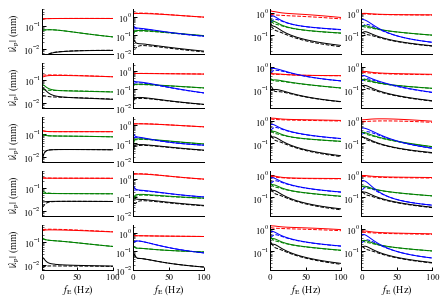

In [26]:
plt.rcParams.update({
    'font.size': 9,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1.
num = 0
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth

fig = plt.figure(figsize=(7, 4.8))
numcol = [0, 2, 4, 5, 7]
colspans = [2, 2, 1, 2, 2]
for i in range(5):
    for j in range(5):
        ax = plt.subplot2grid((5, 9), (i, numcol[j]), colspan=colspans[j])
        if j!=2:
            # default biophisics
            ax.semilogy(list_f, data_h5py_default[data_default[0][num]]['polar_soma'][0], color='k', lw=linewidth, ls='--')
            ax.semilogy(list_f, data_h5py_default[data_default[0][num]]['polar_axon'][0], color='r', lw=linewidth, ls='--')
            ax.semilogy(list_f, data_h5py_default[data_default[0][num]]['polar_basal'][0], color='g', lw=linewidth, ls='--')
            if 'polar_apic' in data_h5py_default[data_default[0, num]].keys():
                ax.semilogy(list_f, data_h5py_default[data_default[0][num]]['polar_apic'][0], color='b', lw=linewidth, ls='--')
            if True:
                # inhibitory biophisics
                ax.semilogy(list_f, data_h5py_inh[data_inh[0][num]]['polar_soma'][0], color='k', lw=linewidth)
                ax.semilogy(list_f, data_h5py_inh[data_inh[0][num]]['polar_axon'][0], color='r', lw=linewidth)
                ax.semilogy(list_f, data_h5py_inh[data_inh[0][num]]['polar_basal'][0], color='g', lw=linewidth)
                if 'polar_apic' in data_h5py_inh[data_inh[0, num]].keys():
                    ax.semilogy(list_f, data_h5py_inh[data_inh[0][num]]['polar_apic'][0], color='b', lw=linewidth)
            if False:
                # excitatory biophisics
                ax.semilogy(list_f, data_h5py_exc[data_exc[0][num]]['polar_soma'][0], color='k', lw=linewidth)
                ax.semilogy(list_f, data_h5py_exc[data_exc[0][num]]['polar_axon'][0], color='r', lw=linewidth)
                ax.semilogy(list_f, data_h5py_exc[data_exc[0][num]]['polar_basal'][0], color='g', lw=linewidth)
                if 'polar_apic' in data_h5py_inh[data_exc[0, num]].keys():
                    ax.semilogy(list_f, data_h5py_exc[data_exc[0][num]]['polar_apic'][0], color='b', lw=linewidth)
        num += 1
        ax.set_xlim(0, 100)
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_linewidth(linewidth)
        ax.spines['left'].set_linewidth(linewidth)
        if j == 0:
            ax.set_ylim(6e-3, 5e-1)
        if j == 1:
            ax.set_ylim(1e-2, 2.5e0)
        if j == 2:
            ax.set_ylim(1.5e-2, 1e0)
        if j == 3:
            ax.set_ylim(1.5e-2, 1.4e0)
        if j == 4:
            ax.set_ylim(1.5e-2, 1.4e0)
            
        if i!=4:
            ax.set_xticks([])
        if i==4:
            ax.set_xticks([0, 50, 100])
        ax.tick_params(axis='y', pad=1)
        ax.tick_params(axis='x', pad=3)
        if i==4:
            ax.set_xlabel('$f_{\mathrm{E}}$ (Hz)', fontsize=10, fontfamily='Times new roman', labelpad=2)
        if j==0:
            ax.set_ylabel("$|\lambda _{\mathrm{p}}|$ (mm)", fontsize=10, fontfamily='Times new roman', labelpad=2)
        if j==2:
            ax.axis('off')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=0.2)   